In [60]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch
from tqdm.auto import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

## 1. Read Files

In [2]:
df = pd.read_csv('results-gpt35.csv')

In [4]:
df.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by going to the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,"I am sorry, but there is no direct link provid...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the course does not have a GitHub reposito...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,Based on the information provided in the FAQ d...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [5]:
df['answer_orig'][0]

'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork'

In [6]:
df['question'][0]

'Where can I sign up for the course?'

In [7]:
df['answer_llm'][0]

'You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.'

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   answer_llm   1830 non-null   object
 1   answer_orig  1830 non-null   object
 2   document     1830 non-null   object
 3   question     1830 non-null   object
 4   course       1830 non-null   object
dtypes: object(5)
memory usage: 71.6+ KB


In [8]:
df4 = pd.read_csv('results-gpt4o.csv')

In [9]:
df4.head()

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [11]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   answer_llm   1830 non-null   object
 1   answer_orig  1830 non-null   object
 2   document     1830 non-null   object
 3   question     1830 non-null   object
 4   course       1830 non-null   object
dtypes: object(5)
memory usage: 71.6+ KB


In [12]:
result_4o = df4.to_dict(orient='records')

In [14]:
result_4o[0]

{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

## 2. Model & Elastic search 

In [18]:
model = SentenceTransformer( 'multi-qa-MiniLM-L6-cos-v1')

c:\Users\HSUPC\monitoring\.venv\lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [20]:
es_client = Elasticsearch('http://localhost:9200')

In [22]:
es_client.info()

ObjectApiResponse({'name': 'c94a9fa56e92', 'cluster_name': 'docker-cluster', 'cluster_uuid': '87OVNLdITq6vU8NS6bsMBw', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [71]:
index_name = 'course_questions'

In [80]:
index_setting = {
    'settings':{
        'number_of_shards':1,
        'number_of_replicas':0
    },
    'mappings': {
        'properties':
        {
            'text': {'type':'text'},
            'question': {'type':'text'},
            'course': {'type':'keyword'},
            'section': {'type':'keyword'},
            'id': {'type':'keyword'},
            'vtq': {
                'type': 'dense_vector',
                'dims': 384,
                'index': True,
                'similarity':'cosine',
            }
        }
    }
}

In [81]:
es_client.indices.create(index= index_name, body = index_setting)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course_questions'})

## 3. Encode data & calculate similarity for gpt-4o

In [15]:
def compute_similarity(data):
    answer_orig = data['answer_orig']
    answer_llm = data['answer_llm']

    v_orig = model.encode(answer_orig)
    v_llm = model.encode(answer_llm)

    return v_orig.dot(v_llm)

In [25]:
similarity =[]
for i in result_4o:
    sim = compute_similarity(i)
    similarity.append(sim)

In [27]:
len(similarity)

1830

In [29]:
similarity[:5]

[0.5345328, 0.69612145, 0.7175138, -0.0003277138, 0.38761964]

In [32]:
df4['consine'] = similarity

In [45]:
df4 = df4.rename(columns={'consine':'cosine'})

In [46]:
df4.head()

,answer_llm,answer_orig,document,question,course,cosine
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp,0.534533
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp,0.696121
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp,0.717514
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp,-0.000328
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp,0.387620


In [47]:
df4['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995338
Name: cosine, dtype: float64

In [35]:
pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.2.1-cp39-cp39-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp39-cp39-win_amd64.whl.metadata (165 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 4.2 MB/s eta 0:00:03
   -------------- ------------------------- 2.9/7.8 MB 7.0 MB/s eta 0:00:01
   ---------------------- ----------------- 4.5/7.8 MB 7.5 MB/s eta 0:00:01
   -------------------------------- ------- 6.3/7.8 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 7.4 MB/s eta 0:00:00
Using cached contourpy-1.2.1-cp39-cp39-win_amd64.whl (182 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.1-cp39-cp39-win_amd64.whl (2.2 MB)


C:\Users\HSUPC\AppData\Local\Temp\ipykernel_4724\666062324.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

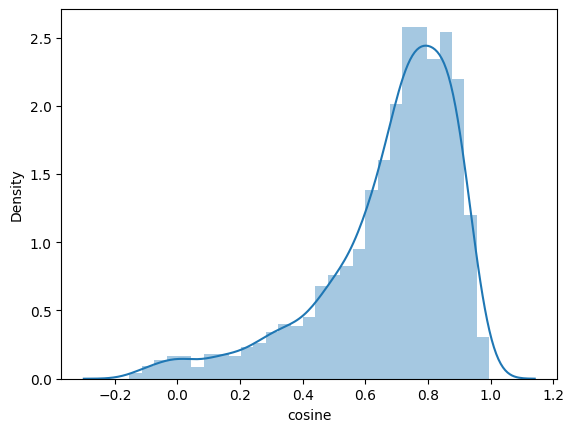

In [48]:
sns.distplot(df4['cosine'])

## 4. Encode & calculate similarity for gpt-3.5

In [49]:
df.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by going to the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,"I am sorry, but there is no direct link provid...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the course does not have a GitHub reposito...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,Based on the information provided in the FAQ d...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [50]:
result_35 = df.to_dict(orient='records')

In [51]:
result_35[0]

{'answer_llm': 'You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [52]:
similarity35 = []
for i in tqdm(result_35):
    sim = compute_similarity(i)
    similarity35.append(sim)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:33<00:00, 11.92it/s]


In [53]:
df['cosine'] = similarity35
df['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546505
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

C:\Users\HSUPC\AppData\Local\Temp\ipykernel_4724\3710624747.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

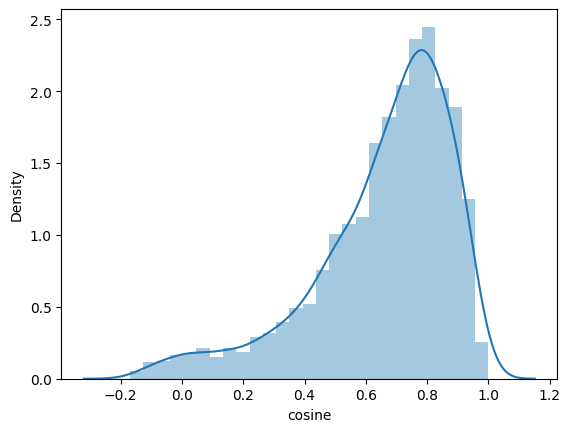

In [54]:
sns.distplot(df['cosine'])

C:\Users\HSUPC\AppData\Local\Temp\ipykernel_4724\3804640755.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['cosine'], label='gpt-4o' )
C:\Users\HSUPC\AppData\Local\Temp\ipykernel_4724\3804640755.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cosine'], label = 'gpt-3.5')


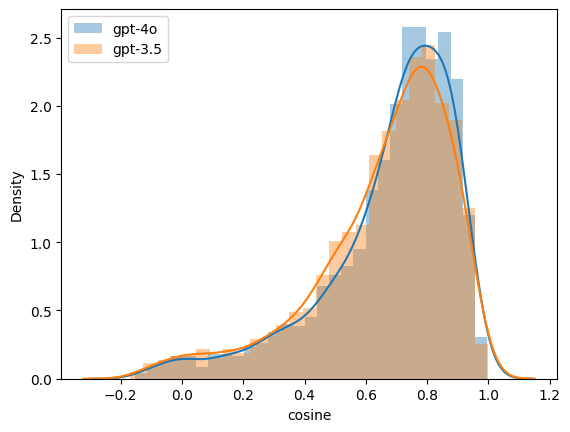

In [61]:
sns.distplot(df4['cosine'], label='gpt-4o' )
sns.distplot(df['cosine'], label = 'gpt-3.5')
plt.legend()

## 5. Encode data & calculate similarity for gpt-4o mini

In [62]:
df4m = pd.read_csv('results-gpt4o-mini.csv')

In [63]:
df4m.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [64]:
result_4om = df4m.to_dict(orient='records')

In [65]:
result_4om[0]

{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [66]:
similarity4m = []
for i in tqdm(result_4om):
    sim = compute_similarity(i)
    similarity4m.append(sim)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:52<00:00, 10.64it/s]


In [69]:
df4m['cosine'] = similarity4m
df4m['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

C:\Users\HSUPC\AppData\Local\Temp\ipykernel_4724\3590663481.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['cosine'], label='gpt-4o' )
C:\Users\HSUPC\AppData\Local\Temp\ipykernel_4724\3590663481.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cosine'], label = 'gpt-3.5')
C:\User

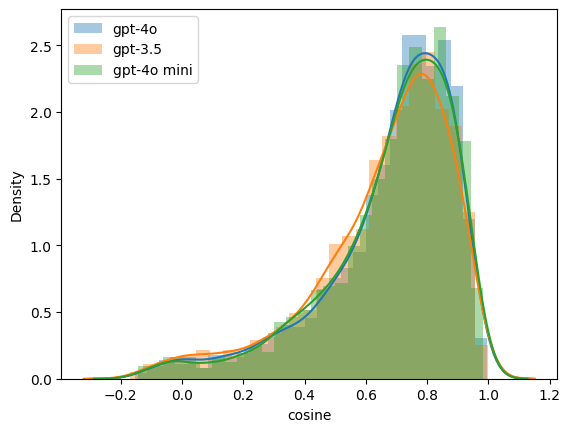

In [70]:
sns.distplot(df4['cosine'], label='gpt-4o' )
sns.distplot(df['cosine'], label = 'gpt-3.5')
sns.distplot(df4m['cosine'], label = 'gpt-4o mini')
plt.legend()

## Online Evaluation

In [82]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [83]:
df4msmaple = df4m.sample(n = 150, random_state= 42)

In [84]:
df4msmaple

,answer_llm,answer_orig,document,question,course,cosine
247,To format a number to 3 decimal places using f...,You can use round() function or f-strings\nrou...,67afabf5,Can you demonstrate using f-strings to format ...,machine-learning-zoomcamp,0.750198
1293,To avoid syntax errors instead of using `aws e...,The command aws ecr get-login --no-include-ema...,53f3ee10,What command should I use instead of aws ecr g...,machine-learning-zoomcamp,0.928495
1563,"In the Projects section, a problem title provi...",Problem description\nSolution description\n(op...,de650b41,What information does a problem title provide ...,machine-learning-zoomcamp,0.689973
1101,To avoid using `np.sqrt()` when calculating Ro...,Instead of using np.sqrt() as the second step....,a7e7cdd2,What argument should be added to mean_squared_...,machine-learning-zoomcamp,0.694671
1161,Osman Ali provides a simplified guide to insta...,In order to run tensorflow with gpu on your lo...,c3ba4459,Who provides a simplified guide to install CUD...,machine-learning-zoomcamp,0.421138
...,...,...,...,...,...,...
1765,"Yes, you can find instructions for installing ...",Refer to https://github.com/DataTalksClub/mach...,e1dc1ed9,Does anyone have a guide for Mac M1 environmen...,machine-learning-zoomcamp,0.610158
554,"Yes, the correlation coefficient should be con...",Should correlation be calculated after splitti...,e31051f7,Should the correlation coefficient be in absol...,machine-learning-zoomcamp,0.529486
367,The mean is no longer representative in a long...,One of the most important characteristics of t...,94f928d2,Why is the mean no longer representative in a ...,machine-learning-zoomcamp,0.780714
1767,"Yes, there is a GitHub link for the Mac M1 env...",Refer to https://github.com/DataTalksClub/mach...,e1dc1ed9,Is there a GitHub link for Mac M1 environment ...,machine-learning-zoomcamp,0.698192


In [86]:
samples = df4msmaple.to_dict(orient='records')

In [87]:
sample1 = samples[0]

In [88]:
sample1

{'answer_llm': "To format a number to 3 decimal places using f-strings, you can use the following syntax:\n\n```python\nprint(f'Average mark for the Homework is {avg:.3f}')\n```\n\nThis will display the value of `avg` rounded to 3 decimal places.",
 'answer_orig': "You can use round() function or f-strings\nround(number, 4)  - this will round number up to 4 decimal places\nprint(f'Average mark for the Homework is {avg:.3f}') - using F string\nAlso there is pandas.Series. round idf you need to round values in the whole Series\nPlease check the documentation\nhttps://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.round.html#pandas.Series.round\nAdded by Olga Rudakova",
 'document': '67afabf5',
 'question': 'Can you demonstrate using f-strings to format a number to 3 decimal places?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.7501978874206543}

In [89]:
sample_p = prompt1_template.format(**sample1)
print(sample_p)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: You can use round() function or f-strings
round(number, 4)  - this will round number up to 4 decimal places
print(f'Average mark for the Homework is {avg:.3f}') - using F string
Also there is pandas.Series. round idf you need to round values in the whole Series
Please check the documentation
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.round.html#pandas.Series.round
Added by Olga Rudakova
Generated Question: Can you demonstrate using f-strings to format a number to 3 decimal places?
Generated Answer: To format a number to 3 decimal places using f-strings, you can use the

In [90]:
import google.generativeai as genai

In [91]:
modelg = genai.GenerativeModel()

In [95]:
sample_r = modelg.generate_content(sample_p)

In [98]:
import json

In [99]:
json.loads(sample_r.text)

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer is relevant because it provides an example of how to use f-strings to format a number to 3 decimal places. This is the same information that is provided in the original answer, although the generated answer provides a more specific example.'}

In [100]:
sample2 = samples[1]

In [101]:
sample2

{'answer_llm': 'To avoid syntax errors instead of using `aws ecr get-login --no-include-email`, you should use the command: \n\n```bash\naws ecr get-login-password\n```\n\nYou can simplify the login process with this command:\n\n```bash\nexport PASSWORD=`aws ecr get-login-password`\ndocker login -u AWS -p $PASSWORD <ACCOUNT_NUMBER>.dkr.ecr.<REGION>.amazonaws.com/clothing-tflite-images\n``` \n\nMake sure to replace `<ACCOUNT_NUMBER>` and `<REGION>` with your actual values.',
 'answer_orig': 'The command aws ecr get-login --no-include-email returns an invalid choice error:\nThe solution is to use the following command instead:  aws ecr get-login-password\nCould simplify the login process with, just replace the <ACCOUNT_NUMBER> and <REGION> with your values:\nexport PASSWORD=`aws ecr get-login-password`\ndocker login -u AWS -p $PASSWORD <ACCOUNT_NUMBER>.dkr.ecr.<REGION>.amazonaws.com/clothing-tflite-images\nAdded by Martin Uribe',
 'document': '53f3ee10',
 'question': 'What command should

In [102]:
print(prompt2_template.format(**sample2))

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What command should I use instead of aws ecr get-login --no-include-email to avoid syntax errors?
Generated Answer: To avoid syntax errors instead of using `aws ecr get-login --no-include-email`, you should use the command: 

```bash
aws ecr get-login-password
```

You can simplify the login process with this command:

```bash
export PASSWORD=`aws ecr get-login-password`
docker login -u AWS -p $PASSWORD <ACCOUNT_NUMBER>.dkr.ecr.<REGION>.amazonaws.com/clothing-tflite-images
``` 

Make sure to replace `<ACCOUNT_NUMBER>` and `<REGION>` with your actual values.

Please analyze the content and context of the generated answer in relation to the question
and provide y

In [104]:
sample_r2 = modelg.generate_content(prompt2_template.format(**sample2)).text

In [105]:
json.loads(sample_r2)

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer provides a valid alternative command to avoid syntax errors for ECR login (`aws ecr get-login-password`) and also includes additional instructions to simplify the login process, which are helpful and relevant to the question.'}